This notebook was created by Donna Faith Go.

In [1]:
import sys
!{sys.executable} -m pip install dtw-python

In [2]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd 
import pickle
import numpy as np
import seaborn as sns
from typing import Tuple

# webscraping
import requests
from bs4 import BeautifulSoup

# data gathering
import yfinance as yf
import time

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# dynamic time warping
from dtaidistance import dtw

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Step 1: Data Gathering

### world indices

In [3]:
# setting up
url = "https://finance.yahoo.com/markets/world-indices/"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table')

# scrapign the data
data = []
for row in table.find_all('tr')[1:]:
    cols = row.find_all('td')
    if cols:
        symbol = cols[0].text.strip()
        name = cols[1].text.strip() if len(cols) > 1 else ''
        data.append([symbol, name])

# turn to dataframe
df = pd.DataFrame(data, columns=['Symbol', 'Name'])
major_indices = list(df['Symbol'])

### yfinance

In [4]:
# getting closing prices for the 30 stocks with batching
start_date = '2015-01-01'
end_date = '2026-01-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

In [5]:
# # Download the volatility indices
# closing_df = download_stocks_in_batches(
#     ['^VIX'], 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('data/volatility indices.pkl')

In [6]:
# # Download the major stock indices
# closing_df = download_stocks_in_batches(
#     major_indices, 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('data/major stock indices.pkl')

In [7]:
# get the major stock indices data
filepath = r'data/major stock indices.pkl'
with open(filepath, 'rb') as f:
    indices_data = pickle.load(f)

# remove the invalid tickers
indices_data.dropna(how='all', axis=1, inplace=True)

In [8]:
# get the volatility data
filepath = r'data/volatility indices.pkl'
with open(filepath, 'rb') as f:
    volatility_data = pickle.load(f)

## Step 2: EDA

In [9]:
# look at the number of nulls
print(indices_data.isna().mean())

^DJI                0.122854
^GSPC               0.122854
^IXIC               0.122854
^NYA                0.122854
^XAX                0.122854
^BUK100P            0.117221
^FTSE               0.119099
^GDAXI              0.116416
^RUT                0.122854
^VIX                0.122854
MOEX.ME             0.380901
^BFX                0.108369
^FCHI               0.108101
^N100               0.108101
^STOXX50E           0.126073
^AORD               0.117758
^AXJO               0.118294
^BSESN              0.143240
^HSI                0.142436
^STI                0.126073
^JKSE               0.155848
^KLSE               0.146459
^KS11               0.144850
^NZ50               0.137607
^TWII               0.151019
^BVSP               0.134925
^GSPTSE             0.125000
^IPSA               0.570547
^MERV               0.152629
^MXX                0.124195
DX-Y.NYB            0.122586
^125904-USD-STRD    0.123122
^JN0U.JO            0.445815
^TA125.TA           0.225054
000001.SS     

There seems to be a lot of nulls in the dataset.
These nulls will have to be either imputed or kept as a null value.

In [10]:
print(indices_data.shape)
print(volatility_data.shape)

(3728, 40)
(3270, 1)


There is a difference in the number of entries. This has to be consolidated to ensure that we are only looking at overlapping dates.

## Step 3: Data Preprocessing

### null handling

In [11]:
# dropping all weekends
indices_data.dropna(how='all', axis=0, inplace=True)
volatility_data.dropna(how='all', axis=0, inplace=True)

# dropping all columns with at least 20% nulls
mask = (
    indices_data[
        indices_data.columns[
            indices_data.isna().mean() > 0.2
            ]
        ].columns
)
indices_data.drop(columns=mask, inplace=True)

# ensure they have the same indices
indices_data = indices_data.loc[volatility_data.index.intersection(indices_data.index)]

### real closing prices

### stationarity

In [12]:
# making data stationary
tau_val = 5
log_returns = np.log(indices_data).diff(tau_val).dropna(how='all')
simple_returns = 100 * indices_data.pct_change().dropna(how='all')

## Step 4: Gidea and Katz

### Embedding data

In [13]:
def create_xy(series: pd.Series, lookback: int = 12, horizon: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """Create the X and y arrays from a pd.Series object. The `lookback`
    determines the number of features we would include in X. While the
    `horizon` paramter informs us how many points we'll need to forecast.

    Paramters:
    ----------
    series (pd.Series): the (n, 1) time series to be sliced into X and Y
    lookback (int): the lookback window to consider (default=12)
    horizon (int): the number of points to forecast for each row in X (default=1)

    Returns:
    -------
    (X, y) (Tuple): a tuple of ndarrays
    """
    x = []
    y = []
    
    series_size = series.shape[0]
    for i in range(series_size):
        
        # break loop if series is less than the required time horizon
        if series.iloc[(i + lookback): (i + lookback + horizon)].shape[0] < horizon:
            break
        x.append(
            series.iloc[i: (i + lookback)]
        )
        y.append(
            series.iloc[(i + lookback): (i + lookback + horizon)]
        )
    x = np.dstack(x)
    y = np.dstack(y)

    # Reshape x to (samples, features, lookback)
    x = np.swapaxes(x, 0, 2)
    # Then flatten (samples, features * lookback)
    x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

    # Reshape y tp (samples, horizon)
    y = np.swapaxes(y, 0, 2)
    y = y[:, :, 0]


    
    return x, np.array(y).flatten()

In [14]:
# storing data
embedded_data = []
stocks = []

# setting constants
dim_size = 25
for col in indices_data.columns:
    embedded, value = create_xy(
        log_returns[col], dim_size
    )
    embedded_data.append(embedded)
    stocks.append(col)

# convert to numpy array
embedded_data = np.array(embedded_data)
stocks = np.array(stocks)

### Volatility Index

In [15]:
def get_l1_l2_norms(data):
    # store data
    l1_norms = []
    l2_norms = []

    # get l1 and l2 norms
    for i in range(len(data)):
        masked = data[i][~np.isnan(data[i])]
        l1 = np.linalg.norm(masked, ord=1)
        l2 = np.linalg.norm(masked, ord=2)
        l1_norms.append(l1)
        l2_norms.append(l2)
    return l1_norms, l2_norms

In [16]:
# # get lp norms
# dates = indices_data[dim_size:].index
# vix_data = volatility_data[['^VIX']]

# for idx in range(embedded_data.shape[0]):
#     l1, l2 = get_l1_l2_norms(embedded_data[idx])
#     stock = stocks[idx]
#     plot_dates = dates[:len(l1)]


#     # plot the landscapes and VIX
#     fig, ax1 = plt.subplots(figsize=(15, 5))
#     ax1.plot(plot_dates, l1, label="L1 Norms")
#     ax1.plot(plot_dates, l2, label="L2 Norms")
#     ax1.set_xlabel("Date")
#     ax1.set_ylabel("Lp Norms")
#     # ax1.set_ylim(0, tau_val + 1)
    
#     ax2 = ax1.twinx()
#     ax2.plot(
#         vix_data.index, vix_data.values, label="VIX", 
#         alpha=0.3, color='green', linestyle='-.'
#     )
#     ax2.set_ylabel("VIX")
    
#     # Combine legends
#     lines_1, labels_1 = ax1.get_legend_handles_labels()
#     lines_2, labels_2 = ax2.get_legend_handles_labels()
#     ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
    
#     title = f'Lp Norms and VIX of the {stock} with Lag {tau_val} and Window {dim_size}'
#     plt.title(title)
#     plt.tight_layout()
#     plt.savefig(f'figures/{title}.png')
#     plt.close()

## Step 5: Dynamic Time Warping

In [17]:
# get lp norms
dates = indices_data[dim_size:].index
vix_data = volatility_data[['^VIX']]

for idx in range(embedded_data.shape[0]):
    # get l1 and l2 norms
    l1, l2 = get_l1_l2_norms(embedded_data[idx])
    stock = stocks[idx]
    plot_dates = dates[:len(l1)]

    # conversion
    l1 = np.array(l1)

    # dynamic time warping
    distance, paths = dtw.warping_paths(
        l1, vix_data.values, use_c=False
    )
    best_path = dtw.best_path(paths)
    similarity_score = distance / len(best_path)
    break 
    
    # plotting
    fig = plt.figure(figsize=(15, 5))
    
    # l1 norms
    ax1 = plt.subplot2grid((1, 2), (0, 0))
    ax1.plot(
        vix_data.index[-len(l1):], 
        l1, 
        label='L1 Norms'
    )
    
    # vix 
    ax2 = ax1.twinx()
    ax2.plot(
        vix_data.index, vix_data.values.squeeze(), label="VIX", 
        alpha=0.5, color='green', linestyle='--'
    )
    ax2.set_ylabel('VIX')
    
    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
    ax1.set_title('L1 Norms and VIX')

    # dtw shortest path
    ax3 = plt.subplot2grid((1, 2), (0, 1))
    path = np.array(best_path)
    x_dates = plot_dates[path[:, 0].astype(int)]
    y_dates = vix_data.index[path[:, 1].astype(int)]
    ax3.plot(x_dates, y_dates)
    ax3.set_title('DTW Shortest Path')
    ax3.set_xlabel('L1 Dates')
    ax3.set_ylabel('VIX Dates')
    ax3.grid(True)    
    ax3.tick_params(axis='x', rotation=45)
    ax3.tick_params(axis='y', rotation=45)
    
    title = f'DTW of {stock} with Lag {tau_val} and Window {dim_size}'
    fig.suptitle(title)
    plt.tight_layout()
    # plt.show()

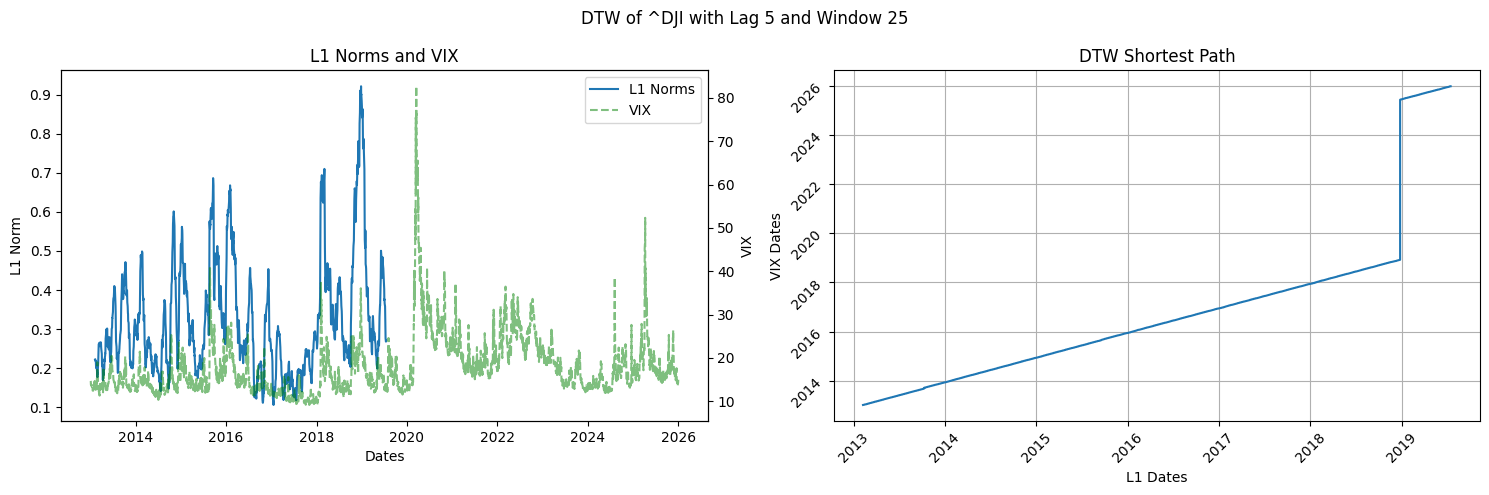

In [72]:
# plotting
fig = plt.figure(figsize=(15, 5))

# l1 norms
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax1.plot(vix_data.index[dim_size:len(l1) + dim_size], l1, label='L1 Norms')
ax1.set_ylabel('L1 Norm')
ax1.set_xlabel('Dates')

# vix 
ax2 = ax1.twinx()
ax2.plot(
    vix_data.index, vix_data.values.squeeze(), label="VIX", 
    alpha=0.5, color='green', linestyle='--'
)
ax2.set_ylabel('VIX')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
ax1.set_title('L1 Norms and VIX')

# dtw shortest path
ax3 = plt.subplot2grid((1, 2), (0, 1)) 
path = np.array(best_path)
x_dates = plot_dates[path[:, 0].astype(int)]
y_dates = vix_data.index[path[:, 1].astype(int)]
ax3.plot(x_dates, y_dates)
ax3.set_title('DTW Shortest Path')
ax3.set_xlabel('L1 Dates')
ax3.set_ylabel('VIX Dates')
ax3.grid(True)    
ax3.tick_params(axis='x', rotation=45)
ax3.tick_params(axis='y', rotation=45)

title = f'DTW of {stock} with Lag {tau_val} and Window {dim_size}'
fig.suptitle(title)
plt.tight_layout()
plt.show()

## Results and Discussion

abc123

## Appendices

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt

# vix_vals = vix_data.values.squeeze()

# plt.figure(figsize=(15, 8))

# # ===============================
# # Original Time Series Plot
# # ===============================
# ax1 = plt.subplot2grid((2, 2), (0, 0))
# ax1.plot(plot_dates, l1, label='L1 Norms')
# ax1.plot(vix_data.index, vix_vals, label='VIX', linestyle='--', alpha=0.6)
# ax1.set_title('Original Time Series')
# ax1.legend()

# # ===============================
# # DTW Shortest Path Plot
# # ===============================
# ax2 = plt.subplot2grid((2, 2), (0, 1))
# path = np.array(best_path)
# ax2.plot(path[:, 0], path[:, 1], color='green', marker='o', linestyle='-')
# ax2.set_title('DTW Shortest Path')
# ax2.set_xlabel('L1 Index')
# ax2.set_ylabel('VIX Index')
# ax2.grid(True)

# # ===============================
# # Point-to-Point DTW Alignment
# # ===============================
# ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
# ax3.plot(plot_dates, l1, label='L1 Norms', marker='o')
# ax3.plot(vix_data.index, vix_vals, label='VIX', linestyle='--', marker='x')

# for a, b in best_path:
#     a, b = int(a), int(b)
#     ax3.plot(
#         [plot_dates[a], vix_data.index[b]],
#         [l1[a], vix_vals[b]],
#         color='grey',
#         linewidth=1,
#         alpha=0.4
#     )

# ax3.set_title('DTW')
# ax3.legend()

# plt.tight_layout()
# plt.show()
